In [1]:
import torch
import sys
import pathlib 
import joblib
import pandas as pd
import numpy as np
import json
import optuna
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
script_directory = pathlib.Path("../2.train-VAE/utils/").resolve()
sys.path.insert(0, str(script_directory))
from betatcvae import BetaTCVAE, compile_tc_vae, tc_weights, extract_latent_dimensions
from optimize_utils_tcvae import get_optimizer_tc

script_directory = pathlib.Path("../utils/").resolve()
sys.path.insert(0, str(script_directory))
from data_loader import load_train_test_data

In [2]:
# Load data
data_directory = pathlib.Path("../0.data-download/data").resolve()
train_data, test_data, val_data, load_gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True, zero_one_normalize=True
)

train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)

In [3]:
# Load the best hyperparameters
study_name = "BetaTCVAE-Optimization"
storage_name = f"sqlite:///./{study_name}.db"
study = optuna.load_study(study_name=study_name, storage=storage_name)
best_trial = study.best_trial

latent_dim = best_trial.params['latent_dim']
beta = best_trial.params['beta']
learning_rate = best_trial.params['learning_rate']
batch_size = best_trial.params['batch_size']
epochs = best_trial.params['epochs']
optimizer = best_trial.params['optimizer_type']

# Create DataLoader
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_tensor), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(test_tensor), batch_size=batch_size, shuffle=False)

In [4]:
#Initialize the model and optimizer
model = BetaTCVAE(input_dim=train_data.shape[1], latent_dim=latent_dim, beta=beta)
optimizer = get_optimizer_tc(optimizer, model.parameters(), learning_rate)

# Training model
train_loss_history, val_loss_history, test_loss_history = compile_tc_vae(model, train_loader, val_loader, test_loader, optimizer, epochs)

Epoch 1, Train Loss: 893.6579815764925, Val Loss: 677.9835951063368, Test Loss: 680.1327921549479
Epoch 2, Train Loss: 345.16764426160216, Val Loss: 129.5224092271593, Test Loss: 132.42439948187933
Epoch 3, Train Loss: 70.98296417691814, Val Loss: 43.81862301296658, Test Loss: 45.8649656507704
Epoch 4, Train Loss: 36.14754055649487, Val Loss: 33.38324801127116, Test Loss: 34.44152514139811
Epoch 5, Train Loss: 31.608515725206974, Val Loss: 29.64200062221951, Test Loss: 31.24074872334798
Epoch 6, Train Loss: 29.731912504737057, Val Loss: 28.367658191257053, Test Loss: 29.371404223971897
Epoch 7, Train Loss: 28.248490882987408, Val Loss: 27.334015952216255, Test Loss: 28.529035780164932
Epoch 8, Train Loss: 27.653263331171292, Val Loss: 26.71826426188151, Test Loss: 27.19421535068088
Epoch 9, Train Loss: 26.948968505859376, Val Loss: 25.473095364040798, Test Loss: 26.948276943630642
Epoch 10, Train Loss: 26.523507417137942, Val Loss: 24.961987177530926, Test Loss: 26.84372435675727
Epoch

In [5]:
# Save the model
model_path = pathlib.Path("results/best_tc_vae_model.pth")
torch.save(model.state_dict(), model_path)

In [6]:
# Save training history
history = {
    'loss': train_loss_history,
    'val_loss': val_loss_history,
    'test_loss': test_loss_history
}

# Convert the history dictionary into a DataFrame
history_df = pd.DataFrame(history)

# Define the path for the CSV file
history_path = pathlib.Path("results/tc_training_history.csv")

# Save the DataFrame to a CSV file
history_df.to_csv(history_path, index=False)

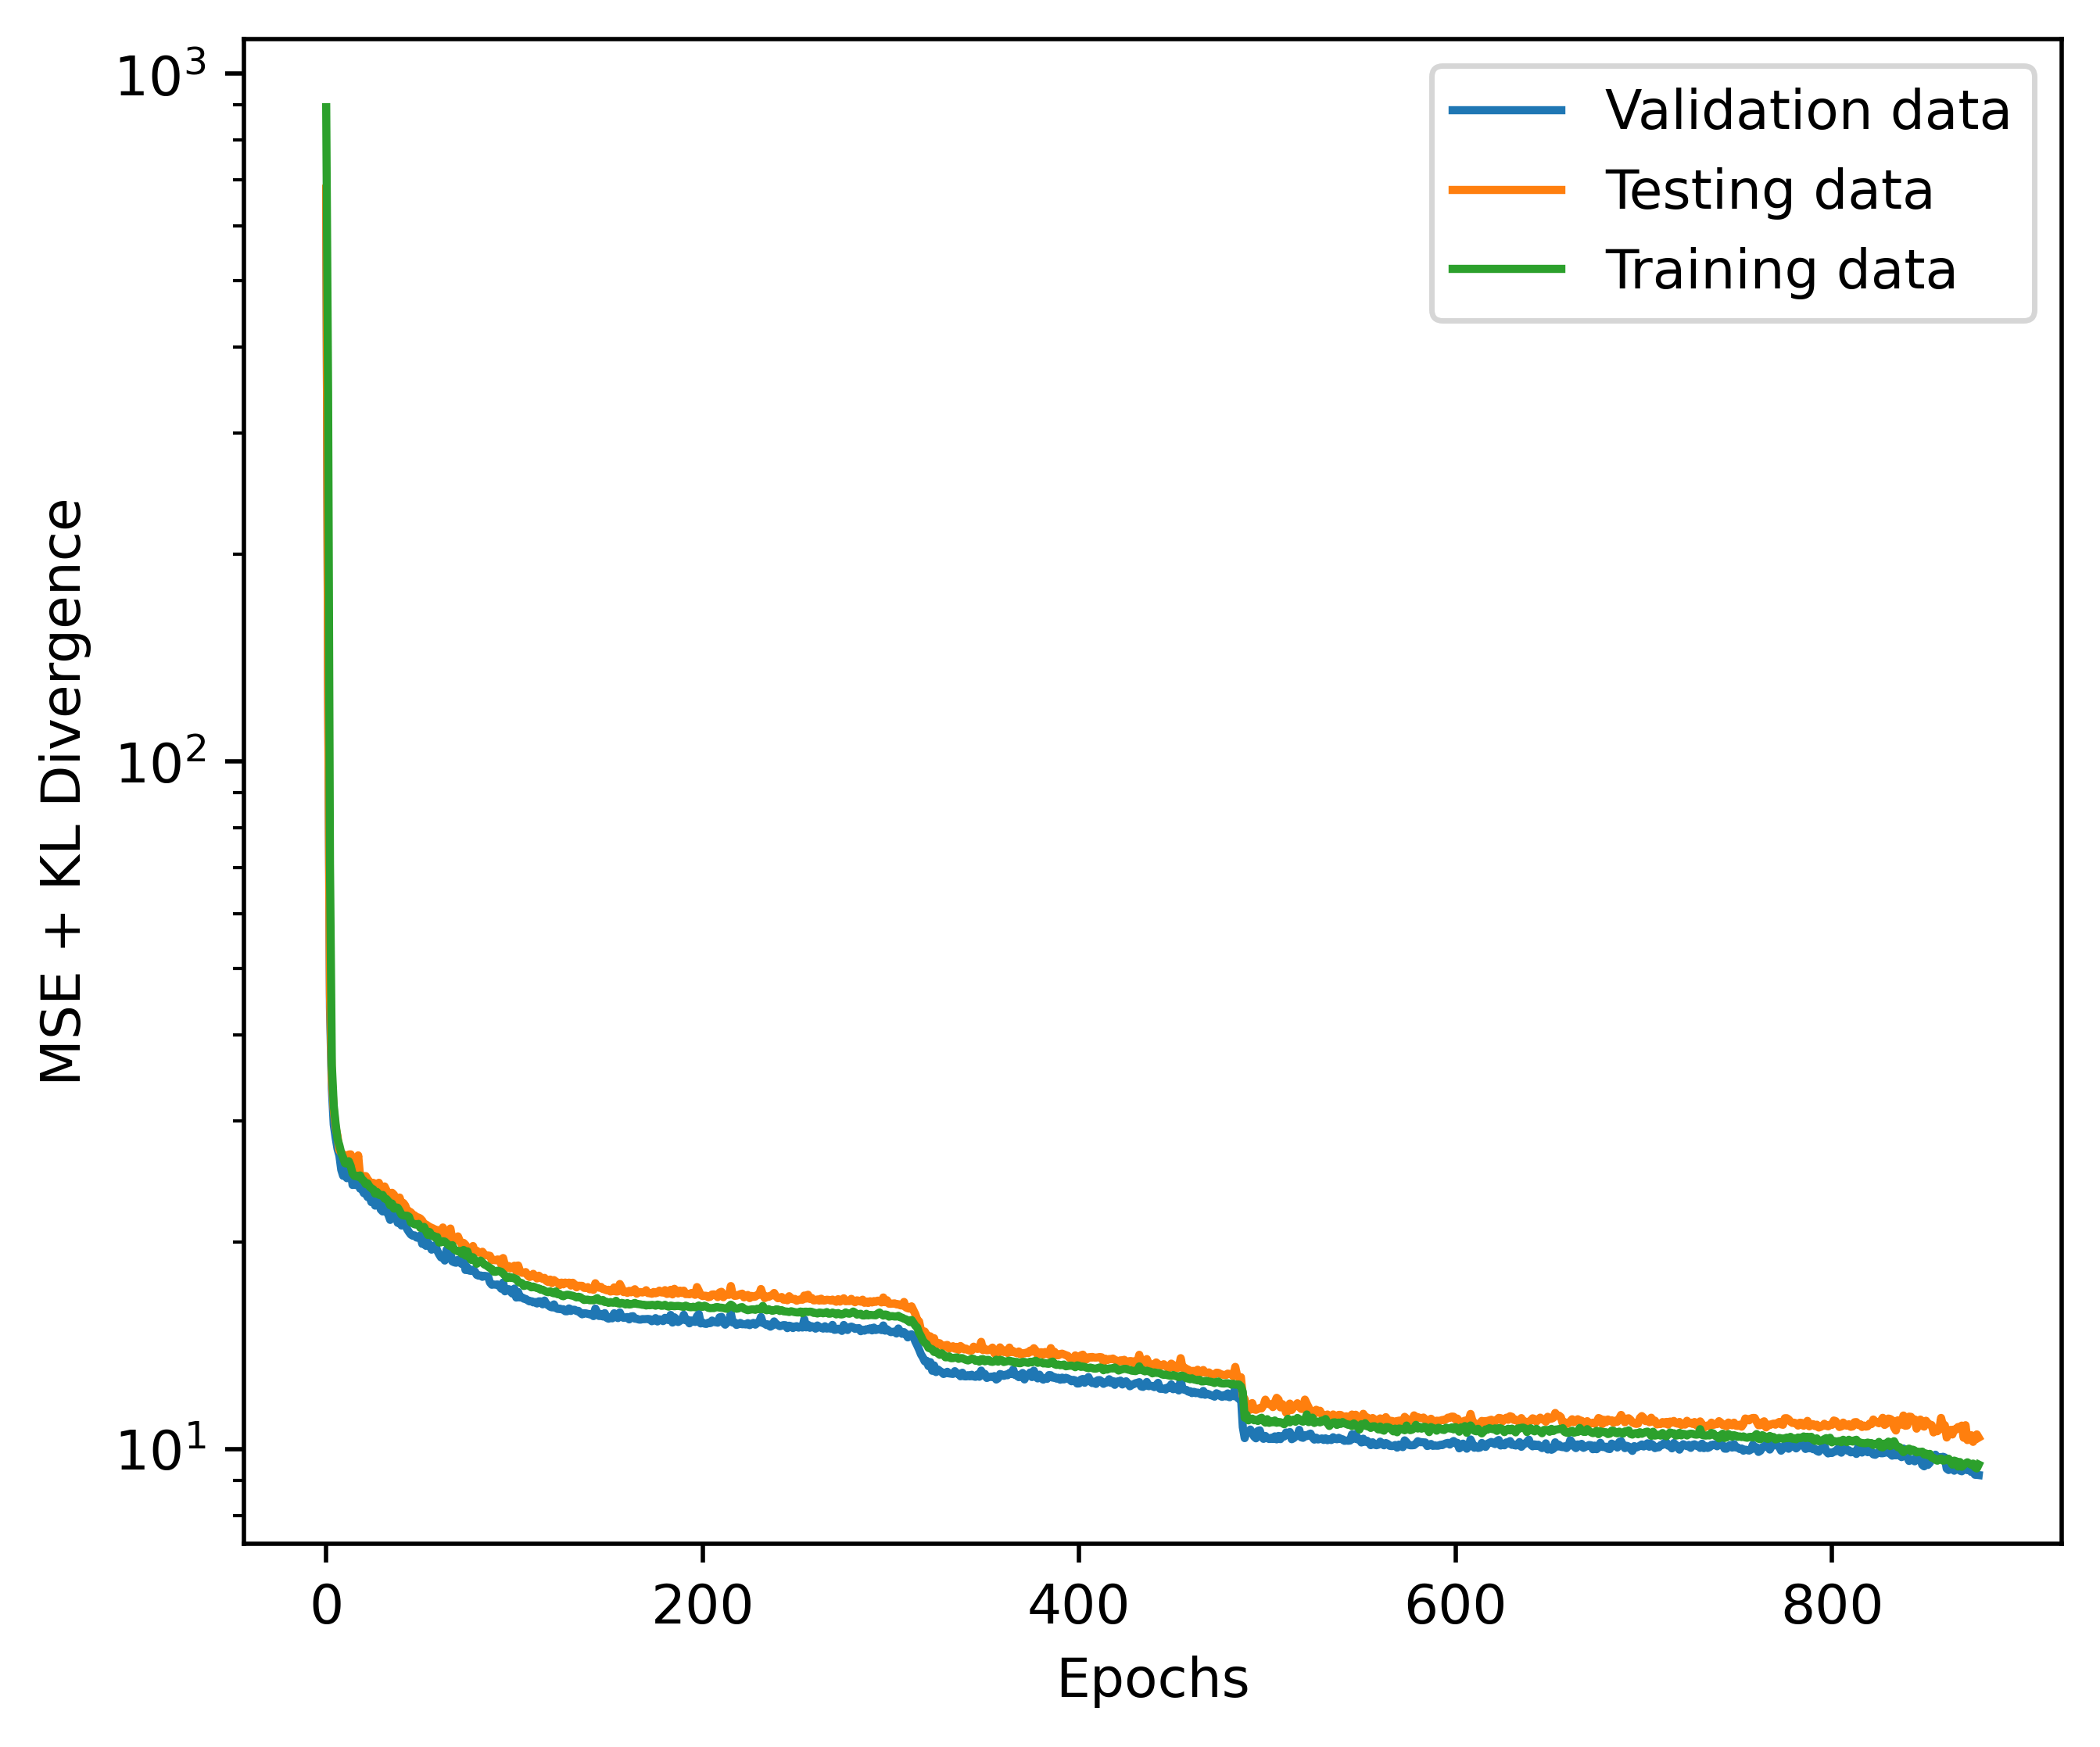

In [7]:
# plot and save the figure
save_path = pathlib.Path("../1.data-exploration/figures/tc_training_curve.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.plot(val_loss_history, label="Validation data")
plt.plot(test_loss_history, label="Testing data")
plt.plot(train_loss_history, label="Training data")
plt.yscale("log")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(save_path)
plt.show()

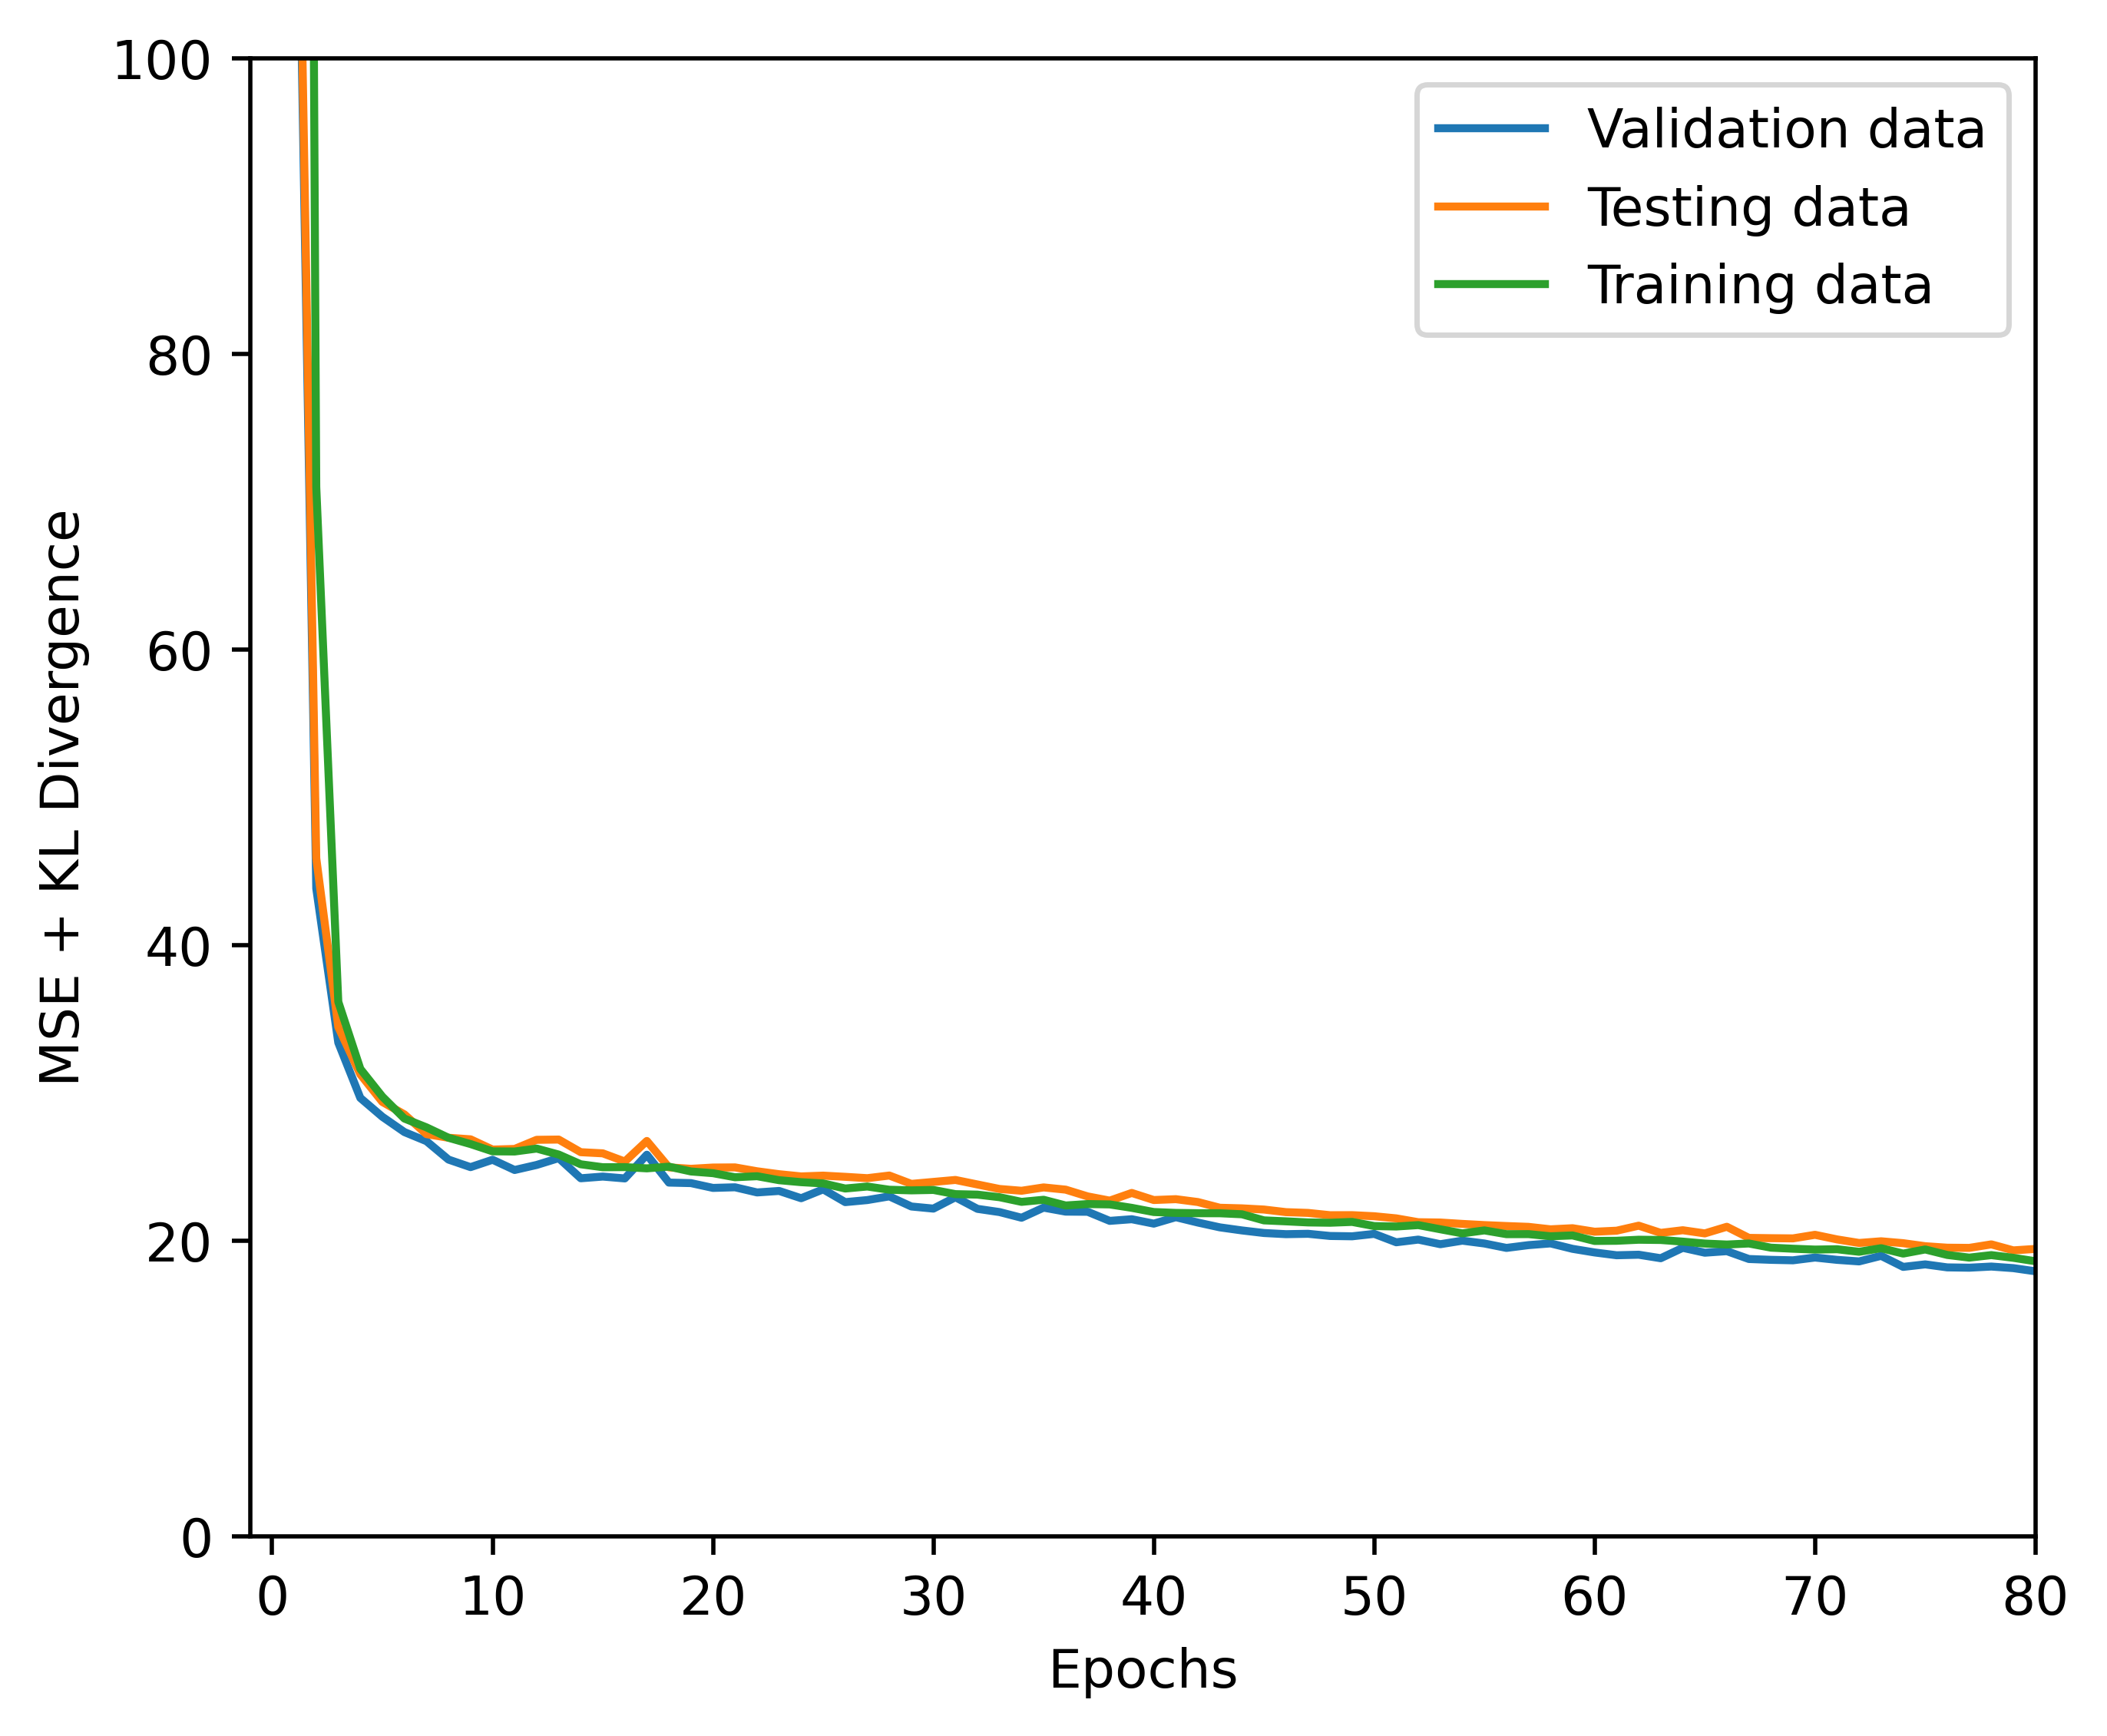

In [8]:
save_path = pathlib.Path("../1.data-exploration/figures/tc_training_curve_elbow.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.xlim(-1,80)
plt.ylim(0,100)
plt.plot(val_loss_history, label="Validation data")
plt.plot(test_loss_history, label="Testing data")
plt.plot(train_loss_history, label="Training data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(save_path)
plt.show()

In [9]:
# Load data
data_directory = pathlib.Path("../0.data-download/data").resolve()
train_df = load_train_test_data(
    data_directory, train_or_test="train", drop_columns=False
)

train_df[["AgeCategory", "Sex"]] = train_df.age_and_sex.str.split(
    pat="_", expand=True
)

# create dataframe containing the genes that passed an initial QC (see Pan et al. 2022) and their corresponding gene label and extract the gene labels
gene_dict_df = pd.read_parquet(
    "../0.data-download/data/CRISPR_gene_dictionary.parquet"
)
gene_list_passed_qc = gene_dict_df.loc[
    gene_dict_df["qc_pass"], "dependency_column"
].tolist()

#Extract and process weights 
path = "./results/weight_matrix_gsea_tc.parquet"
train_data = train_df.filter(gene_list_passed_qc, axis=1)
final_gene_weights_df = tc_weights(model, train_data, path)

In [10]:
# Extract the latent space dimensions
metadata_df_dir = pathlib.Path("../0.data-download/data/metadata_df.parquet")
metadata = pd.read_parquet(metadata_df_dir)

train_and_test_subbed_dir = pathlib.Path("../0.data-download/data/train_and_test_subbed.parquet")
train_and_test_subbed = pd.read_parquet(train_and_test_subbed_dir)


# Convert DataFrame to NumPy and then Tensor
train_test_array = train_and_test_subbed.to_numpy()
train_test_tensor = torch.tensor(train_test_array, dtype=torch.float32)

#Create TensorDataset and DataLoader
tensor_dataset = TensorDataset(train_test_tensor)
train_and_test_subbed_loader = DataLoader(tensor_dataset, batch_size=32, shuffle=False)

path = "./results/tc_latent_df.parquet"

latent_df = extract_latent_dimensions(model, train_and_test_subbed_loader, metadata, path)
print(latent_df.head())

      ModelID         0         1         2         3         4         5  \
0  ACH-000748 -0.133554  0.006017  0.116551 -0.042319 -0.051326 -0.155072   
1  ACH-000645 -0.128797 -0.013983  0.145614 -0.057773 -0.030046 -0.179081   
2  ACH-001301 -0.129908  0.004257  0.115294 -0.038331 -0.049063 -0.159219   
3  ACH-000361 -0.119456  0.016576  0.098045 -0.042944 -0.057588 -0.116084   
4  ACH-000325 -0.141709  0.022249  0.084034 -0.049406 -0.049494 -0.071417   

          6         7         8  ...       183       184       185       186  \
0  0.022478  0.008258  0.023741  ...  0.002896 -0.154704 -0.079079  0.159543   
1  0.010752  0.005933  0.040790  ...  0.016332 -0.210179 -0.101567  0.143474   
2  0.018566  0.000879  0.022523  ...  0.021669 -0.177754 -0.084849  0.155585   
3  0.022606 -0.001621  0.032891  ...  0.022117 -0.138879 -0.058519  0.146072   
4  0.024804 -0.025601  0.021520  ...  0.000674 -0.103260 -0.049710  0.140277   

        187       188       189       190       191     